In [ ]:
import numpy as np

dec_data = np.loadtxt('Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('Test_Dst_NoAuction_DecPre_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 139587)


In [ ]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [ ]:
k = 4 # which prediction horizon
T = 100 # the length of a single input i. e lookback_timestep
n_hiddens = 64
checkpoint_filepath = 'path_to_your_10model_checkpoints'
# checkpoint_filepath = './model_tensorflow2/weights'

In [ ]:
# Training Dataset Shrinking
# dec_train = dec_train[:,:50000]
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 203800)
(203701, 100, 40, 1) (203701, 3)


In [ ]:
# Testing Dataset Shrinking
# dec_test = dec_test[:,:20000]
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 139587)
(139488, 100, 40, 1) (139488, 3)


In [ ]:

# Validation Dataset Shrinking
# dec_val = dec_val[:,:10000]
print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 50950)
(50851, 100, 40, 1) (50851, 3)


In [ ]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(203701, 100, 40, 1) (203701, 3)
(50851, 100, 40, 1) (50851, 3)
(139488, 100, 40, 1) (139488, 3)


In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))

    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)

    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)

    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

2023-11-09 19:13:57.613697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-09 19:13:57.829671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-09 19:13:57.829806: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-09 19:13:57.834680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 20, 32)  96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 20, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 20, 32)  4128        ['leaky_re_lu[0][0]']        

/home/user/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
            epochs=200, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])

2023-11-09 19:14:59.592564: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3259216000 exceeds 10% of free system memory.


Epoch 1/200


2023-11-09 19:42:35.236213: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 813616000 exceeds 10% of free system memory.


1592/1592 - 1740s - loss: 1.0205 - accuracy: 0.4419 - val_loss: 1.0864 - val_accuracy: 0.3815 - 1740s/epoch - 1s/step
Epoch 2/200
1592/1592 - 1568s - loss: 0.9657 - accuracy: 0.5157 - val_loss: 1.0717 - val_accuracy: 0.4320 - 1568s/epoch - 985ms/step
Epoch 3/200
1592/1592 - 1271s - loss: 0.9304 - accuracy: 0.5526 - val_loss: 1.0379 - val_accuracy: 0.4685 - 1271s/epoch - 799ms/step
Epoch 4/200
1592/1592 - 1275s - loss: 0.8947 - accuracy: 0.5783 - val_loss: 1.0184 - val_accuracy: 0.4886 - 1275s/epoch - 801ms/step
Epoch 5/200
1592/1592 - 1275s - loss: 0.8569 - accuracy: 0.6038 - val_loss: 1.0080 - val_accuracy: 0.5037 - 1275s/epoch - 801ms/step
Epoch 6/200
1592/1592 - 1275s - loss: 0.8161 - accuracy: 0.6261 - val_loss: 0.9864 - val_accuracy: 0.5150 - 1275s/epoch - 801ms/step
Epoch 7/200
1592/1592 - 1273s - loss: 0.7732 - accuracy: 0.6493 - val_loss: 0.9897 - val_accuracy: 0.5190 - 1273s/epoch - 800ms/step
Epoch 8/200
1592/1592 - 1274s - loss: 0.7447 - accuracy: 0.6674 - val_loss: 0.9695 -

Epoch 63/200
1592/1592 - 1293s - loss: 0.3772 - accuracy: 0.8596 - val_loss: 1.1006 - val_accuracy: 0.5972 - 1293s/epoch - 812ms/step
Epoch 64/200
1592/1592 - 1299s - loss: 0.3757 - accuracy: 0.8604 - val_loss: 1.0598 - val_accuracy: 0.6023 - 1299s/epoch - 816ms/step
Epoch 65/200
1592/1592 - 1294s - loss: 0.4257 - accuracy: 0.8363 - val_loss: 1.0722 - val_accuracy: 0.6025 - 1294s/epoch - 813ms/step
Epoch 66/200
1592/1592 - 1294s - loss: 0.3691 - accuracy: 0.8630 - val_loss: 1.0780 - val_accuracy: 0.5980 - 1294s/epoch - 813ms/step
Epoch 67/200
1592/1592 - 1292s - loss: 0.3678 - accuracy: 0.8633 - val_loss: 1.1084 - val_accuracy: 0.5978 - 1292s/epoch - 811ms/step
Epoch 68/200
1592/1592 - 1293s - loss: 0.3664 - accuracy: 0.8643 - val_loss: 1.0889 - val_accuracy: 0.5995 - 1293s/epoch - 812ms/step
Epoch 69/200
1592/1592 - 1293s - loss: 0.3642 - accuracy: 0.8648 - val_loss: 1.0949 - val_accuracy: 0.6022 - 1293s/epoch - 812ms/step
Epoch 70/200
1592/1592 - 1294s - loss: 0.3624 - accuracy: 0.86

Epoch 124/200
1592/1592 - 1292s - loss: 0.2824 - accuracy: 0.8966 - val_loss: 1.2450 - val_accuracy: 0.5981 - 1292s/epoch - 811ms/step
Epoch 125/200
1592/1592 - 1290s - loss: 0.2806 - accuracy: 0.8970 - val_loss: 1.2694 - val_accuracy: 0.6020 - 1290s/epoch - 810ms/step
Epoch 126/200
1592/1592 - 1288s - loss: 0.2792 - accuracy: 0.8970 - val_loss: 1.2491 - val_accuracy: 0.5960 - 1288s/epoch - 809ms/step
Epoch 127/200
1592/1592 - 1291s - loss: 0.2772 - accuracy: 0.8991 - val_loss: 1.2347 - val_accuracy: 0.5955 - 1291s/epoch - 811ms/step
Epoch 128/200
1592/1592 - 1289s - loss: 0.2779 - accuracy: 0.8982 - val_loss: 1.2981 - val_accuracy: 0.5963 - 1289s/epoch - 809ms/step
Epoch 129/200
1592/1592 - 1288s - loss: 0.2751 - accuracy: 0.8992 - val_loss: 1.2649 - val_accuracy: 0.6007 - 1288s/epoch - 809ms/step
Epoch 130/200
1592/1592 - 1287s - loss: 0.2754 - accuracy: 0.8988 - val_loss: 1.2508 - val_accuracy: 0.5990 - 1287s/epoch - 809ms/step
Epoch 131/200
1592/1592 - 1291s - loss: 0.2735 - accura

Epoch 185/200
1592/1592 - 1293s - loss: 0.2309 - accuracy: 0.9149 - val_loss: 1.3995 - val_accuracy: 0.5924 - 1293s/epoch - 812ms/step
Epoch 186/200
1592/1592 - 1294s - loss: 0.2290 - accuracy: 0.9157 - val_loss: 1.4745 - val_accuracy: 0.5922 - 1294s/epoch - 813ms/step
Epoch 187/200
1592/1592 - 1298s - loss: 0.2286 - accuracy: 0.9164 - val_loss: 1.4455 - val_accuracy: 0.5950 - 1298s/epoch - 815ms/step
Epoch 188/200
1592/1592 - 1298s - loss: 0.2295 - accuracy: 0.9155 - val_loss: 1.4601 - val_accuracy: 0.5936 - 1298s/epoch - 815ms/step
Epoch 189/200
1592/1592 - 1299s - loss: 0.2280 - accuracy: 0.9163 - val_loss: 1.4025 - val_accuracy: 0.5992 - 1299s/epoch - 816ms/step
Epoch 190/200
1592/1592 - 1293s - loss: 0.2274 - accuracy: 0.9168 - val_loss: 1.4172 - val_accuracy: 0.5928 - 1293s/epoch - 812ms/step
Epoch 191/200
1592/1592 - 1290s - loss: 0.2264 - accuracy: 0.9168 - val_loss: 1.4110 - val_accuracy: 0.5966 - 1290s/epoch - 810ms/step
Epoch 192/200
1592/1592 - 1287s - loss: 0.2261 - accura

In [ ]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)

2023-11-12 19:19:26.543182: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2231808000 exceeds 10% of free system memory.


4359/4359 [==============================] - 228s 50ms/step


In [ ]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.6642148428538656
              precision    recall  f1-score   support

           0     0.6234    0.6884    0.6543     47915
           1     0.7549    0.6862    0.7189     48050
           2     0.6222    0.6134    0.6178     43523

    accuracy                         0.6642    139488
   macro avg     0.6668    0.6626    0.6636    139488
weighted avg     0.6683    0.6642    0.6651    139488



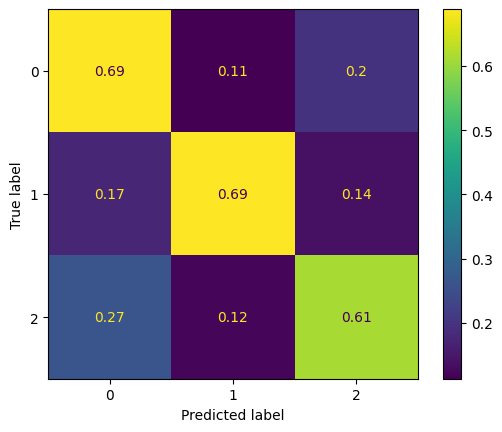

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()